Epoch 1/10 - Loss: 0.5666, Train Acc: 0.7342, Val Acc: 0.7336
  >>> Best model saved at epoch 1 with Val Acc: 0.7336
Epoch 2/10 - Loss: 0.5488, Train Acc: 0.7346, Val Acc: 0.7311
Epoch 3/10 - Loss: 0.5457, Train Acc: 0.7365, Val Acc: 0.7327
Epoch 4/10 - Loss: 0.5450, Train Acc: 0.7276, Val Acc: 0.7215
Epoch 5/10 - Loss: 0.5448, Train Acc: 0.7373, Val Acc: 0.7299
Epoch 6/10 - Loss: 0.5432, Train Acc: 0.7383, Val Acc: 0.7339
  >>> Best model saved at epoch 6 with Val Acc: 0.7339
Epoch 7/10 - Loss: 0.5429, Train Acc: 0.7376, Val Acc: 0.7310
Epoch 8/10 - Loss: 0.5412, Train Acc: 0.7384, Val Acc: 0.7323
Epoch 9/10 - Loss: 0.5410, Train Acc: 0.7380, Val Acc: 0.7314
Epoch 10/10 - Loss: 0.5411, Train Acc: 0.7342, Val Acc: 0.7254

Training complete. Best Val Acc: 0.7339

=== Test Evaluation ===
Test Accuracy : 0.7329
Test F1 Score : 0.7242
Test Precision: 0.7480
Test Recall   : 0.7018
Test AUC      : 0.7960


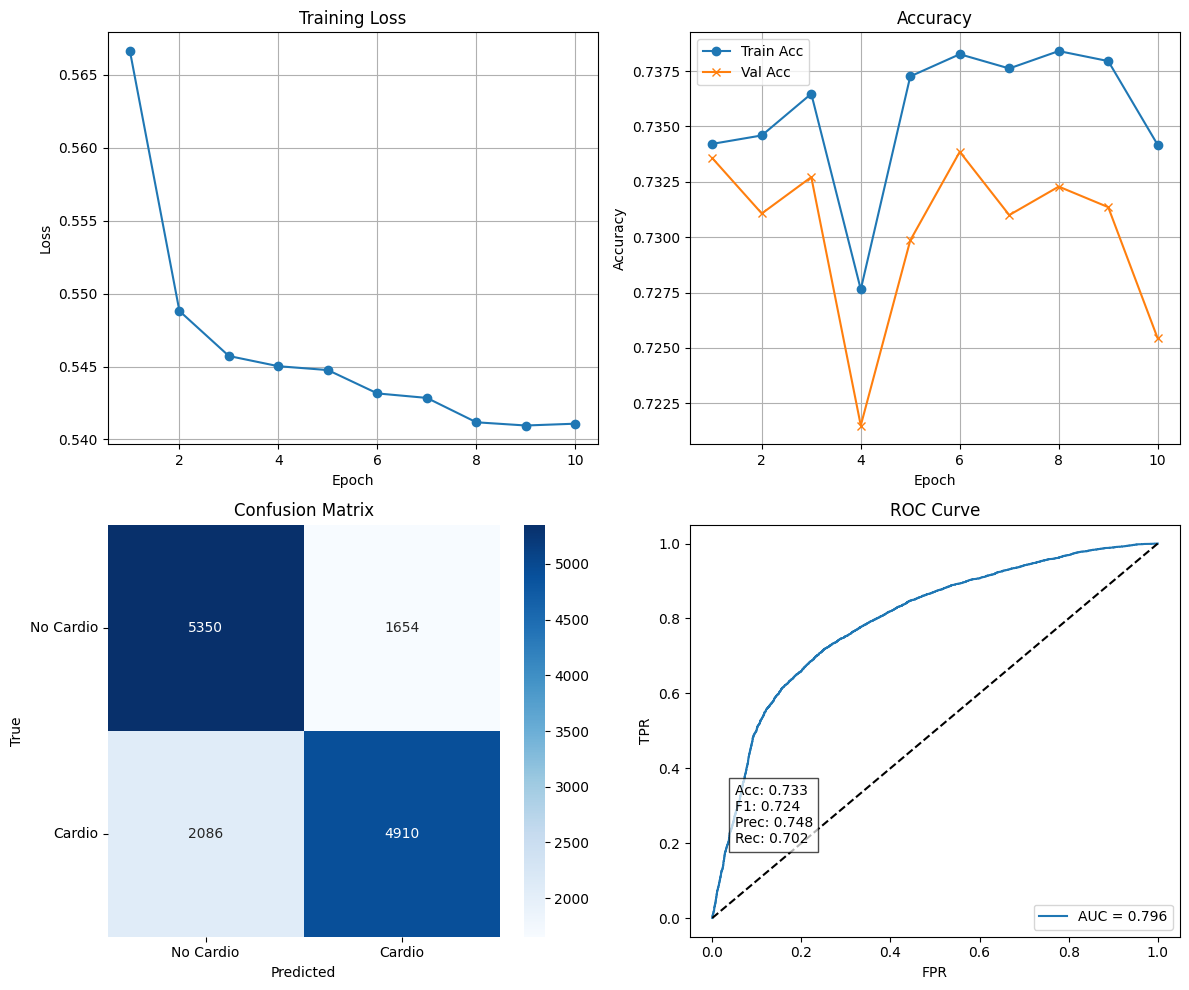

In [ ]:
#モデル保存する，val追加，しかしK-CVじゃなくなった
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    recall_score, roc_auc_score, roc_curve, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
from fttransformer import FTTransformer
import os

# --------------------------------------------
# 設定
# --------------------------------------------
DATA_PATH = "/home/osajima/ドキュメント/program/Transformer_Study/fttransformer_pytorch/cardio_train.csv"
TEST_RATIO = 0.2  # train:val:test = 0.6:0.2:0.2
VAL_RATIO = 0.25  # トレインバリデーション間の分割比率 (0.25 * 0.8 = 0.2)
EPOCHS = 10
BATCH_SIZE = 128
LR = 3e-4
SCRIPT_DIR = os.getcwd()
MODEL_SAVE_PATH = "/home/osajima/ドキュメント/program/Transformer_Study/fttransformer_pytorch/best_model.pth"

# --------------------------------------------
# データ読み込みと前処理
# --------------------------------------------
data = pd.read_csv(DATA_PATH, sep=';')
data = data.drop(columns=["id"])
X = data.drop(columns=["cardio"])
y = data["cardio"]

categorical_cols = ["gender", "cholesterol", "gluc", "smoke", "alco", "active"]
continuous_cols = ["age", "height", "weight", "ap_hi", "ap_lo"]

# カテゴリカル変数のLabel Encoding
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# 連続変数の標準化
scaler = StandardScaler()
X[continuous_cols] = scaler.fit_transform(X[continuous_cols])

# データ分割: train+val と test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=TEST_RATIO, random_state=42, stratify=y
)
# train と val に再分割
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=VAL_RATIO, random_state=42, stratify=y_train_val
)

# Dataset クラス
class CardioDataset(Dataset):
    def __init__(self, X, y):
        self.X_categ = torch.tensor(X[categorical_cols].values, dtype=torch.long)
        self.X_cont = torch.tensor(X[continuous_cols].values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_categ[idx], self.X_cont[idx], self.y[idx]

# 可視化関数
def plot_all_metrics(train_losses, train_accs, val_accs, y_true, y_pred, y_prob):
    cm = confusion_matrix(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    # Training Loss
    axs[0, 0].plot(range(1, len(train_losses) + 1), train_losses, marker='o')
    axs[0, 0].set_title("Training Loss")
    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].grid(True)

    # Accuracy 曲線
    axs[0, 1].plot(range(1, len(train_accs) + 1), train_accs, marker='o', label='Train Acc')
    axs[0, 1].plot(range(1, len(val_accs) + 1), val_accs, marker='x', label='Val Acc')
    axs[0, 1].set_title("Accuracy")
    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].set_ylabel("Accuracy")
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[1, 0])
    axs[1, 0].set_title("Confusion Matrix")
    axs[1, 0].set_xlabel("Predicted")
    axs[1, 0].set_ylabel("True")
    axs[1, 0].set_xticklabels(['No Cardio', 'Cardio'])
    axs[1, 0].set_yticklabels(['No Cardio', 'Cardio'], rotation=0)

    # ROC Curve
    axs[1, 1].plot(fpr, tpr, label=f'AUC = {auc:.3f}')
    axs[1, 1].plot([0, 1], [0, 1], 'k--')
    axs[1, 1].set_title('ROC Curve')
    axs[1, 1].set_xlabel('FPR')
    axs[1, 1].set_ylabel('TPR')
    axs[1, 1].legend(loc='lower right')
    axs[1, 1].text(0.05, 0.2,
                f"Acc: {acc:.3f}\nF1: {f1:.3f}\nPrec: {precision:.3f}\nRec: {recall:.3f}",
                fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

    plt.tight_layout()
    plt.show()

# データローダー
train_loader = DataLoader(CardioDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(CardioDataset(X_val, y_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(CardioDataset(X_test, y_test), batch_size=BATCH_SIZE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# モデル定義
model = FTTransformer(
    categories=[X[col].nunique() for col in categorical_cols],
    num_continuous=len(continuous_cols),
    dim=64, depth=6, heads=8,
    ff_dropout=0.2, attn_dropout=0.2
).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR)

# トレーニングループ + ベストモデル保存
best_val_acc = 0.0
train_losses, train_accs, val_accs = [], [], []

for epoch in range(1, EPOCHS + 1):
    # training
    model.train()
    running_loss = 0.0
    for x_cat, x_cont, labels in train_loader:
        x_cat, x_cont, labels = x_cat.to(device), x_cont.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(x_cat, x_cont)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)

    # train accuracy
    model.eval()
    train_correct = 0
    train_total = 0
    with torch.no_grad():
        for x_cat, x_cont, labels in train_loader:
            x_cat, x_cont, labels = x_cat.to(device), x_cont.to(device), labels.to(device)
            preds = (torch.sigmoid(model(x_cat, x_cont)) > 0.5).float()
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
    train_acc = train_correct / train_total

    # validation
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for x_cat, x_cont, labels in val_loader:
            x_cat, x_cont = x_cat.to(device), x_cont.to(device)
            probs = torch.sigmoid(model(x_cat, x_cont)).cpu().numpy()
            preds = (probs > 0.5).astype(int)
            all_probs.extend(probs.flatten())
            all_preds.extend(preds.flatten())
            all_labels.extend(labels.numpy())
    val_acc = accuracy_score(all_labels, all_preds)

    train_losses.append(avg_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch}/{EPOCHS} - Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # ベストモデル保存
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"  >>> Best model saved at epoch {epoch} with Val Acc: {val_acc:.4f}")

print(f"\nTraining complete. Best Val Acc: {best_val_acc:.4f}")

# テスト評価
# ベストモデル読み込み
best_model = FTTransformer(
    categories=[X[col].nunique() for col in categorical_cols],
    num_continuous=len(continuous_cols),
    dim=64, depth=6, heads=8,
    ff_dropout=0.2, attn_dropout=0.2
).to(device)
best_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
best_model.eval()

y_test_true, y_test_pred, y_test_prob = [], [], []
with torch.no_grad():
    for x_cat, x_cont, labels in test_loader:
        x_cat, x_cont = x_cat.to(device), x_cont.to(device)
        probs = torch.sigmoid(best_model(x_cat, x_cont)).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        y_test_prob.extend(probs.flatten())
        y_test_pred.extend(preds.flatten())
        y_test_true.extend(labels.numpy())

# テストメトリクス出力
test_acc = accuracy_score(y_test_true, y_test_pred)
test_f1 = f1_score(y_test_true, y_test_pred)
test_precision = precision_score(y_test_true, y_test_pred)
test_recall = recall_score(y_test_true, y_test_pred)
test_auc = roc_auc_score(y_test_true, y_test_prob)

print(f"\n=== Test Evaluation ===")
print(f"Test Accuracy : {test_acc:.4f}")
print(f"Test F1 Score : {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall   : {test_recall:.4f}")
print(f"Test AUC      : {test_auc:.4f}")

# テスト結果の可視化
plot_all_metrics(train_losses, train_accs, val_accs, y_test_true, y_test_pred, y_test_prob)
